In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### manually annotated data

In [4]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC


DATASET = '../archive/myo_ds_30l_10ol.npz'
SCORING = ['accuracy', 'f1_macro', 'f1_micro']

data = np.load(DATASET)
X, y = data['X'], data['y']

model = SVC()

results = cross_validate(model, np.median(X, axis=1), y, scoring=SCORING, n_jobs=-1, cv=KFold(5, shuffle=True))
for key, value in results.items():
    print(key)
    print(value)
    print('**********')

fit_time
[0.12310028 0.12158847 0.12159038 0.12374663 0.11974621]
**********
score_time
[0.07356048 0.08207202 0.07255316 0.08106136 0.08506179]
**********
test_accuracy
[0.9025916  0.91152815 0.9106345  0.89722967 0.90348525]
**********
test_f1_macro
[0.89692004 0.90961464 0.9083952  0.89524439 0.90004788]
**********
test_f1_micro
[0.9025916  0.91152815 0.9106345  0.89722967 0.90348525]
**********


### kmeans-annotated data

In [6]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC


K_MEANS_DATASET = '../archive/myo_ds_30l_10ol_kmeans_labels.npz'
SCORING = ['accuracy', 'f1_macro', 'f1_micro']

kdata = np.load(K_MEANS_DATASET)

kX, ky = kdata['X'], kdata['y']

assert not np.any(kX != X), "A comparison with different data is not fair."

model = SVC()

results = cross_validate(model, np.median(kX, axis=1), ky, scoring=SCORING, n_jobs=-1, cv=KFold(5, shuffle=True))
for key, value in results.items():
    print(key)
    print(value)
    print('**********')

fit_time
[0.03453112 0.03409648 0.03609824 0.04761457 0.03761458]
**********
score_time
[0.03791618 0.04125524 0.0352571  0.03825593 0.04325485]
**********
test_accuracy
[0.99016979 0.99106345 0.98659517 0.98659517 0.98748883]
**********
test_f1_macro
[0.98801657 0.98979153 0.98131904 0.98424772 0.98272202]
**********
test_f1_micro
[0.99016979 0.99106345 0.98659517 0.98659517 0.98748883]
**********


# view data

In [9]:
np2img = lambda x: ((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8)

int2gesture = {
    0: 'neutral',
    1: 'flexion',
    2: 'extension',
    7: 'fist'
}

kint2gesture = {
    2: 'neutral',
    0: 'flexion',
    1: 'extension',
    3: 'fist'
}

gesture2intensity = {
    'neutral': 20,
    'flexion': 64,
    'extension': 128,
    'fist': 255
}

DATASET = '../archive/myo_ds_30l_10ol.npz'
K_MEANS_DATASET = '../archive/myo_ds_30l_10ol_kmeans_labels.npz'

kdata = np.load(K_MEANS_DATASET)
kX = kdata['X']
ky = kdata['y']

data = np.load(DATASET)
X = data['X']
y = data['y']

np.any(kX != X)

False

TypeError: 'p' must be an instance of matplotlib.patches.Patch, not a matplotlib.lines.Line2D

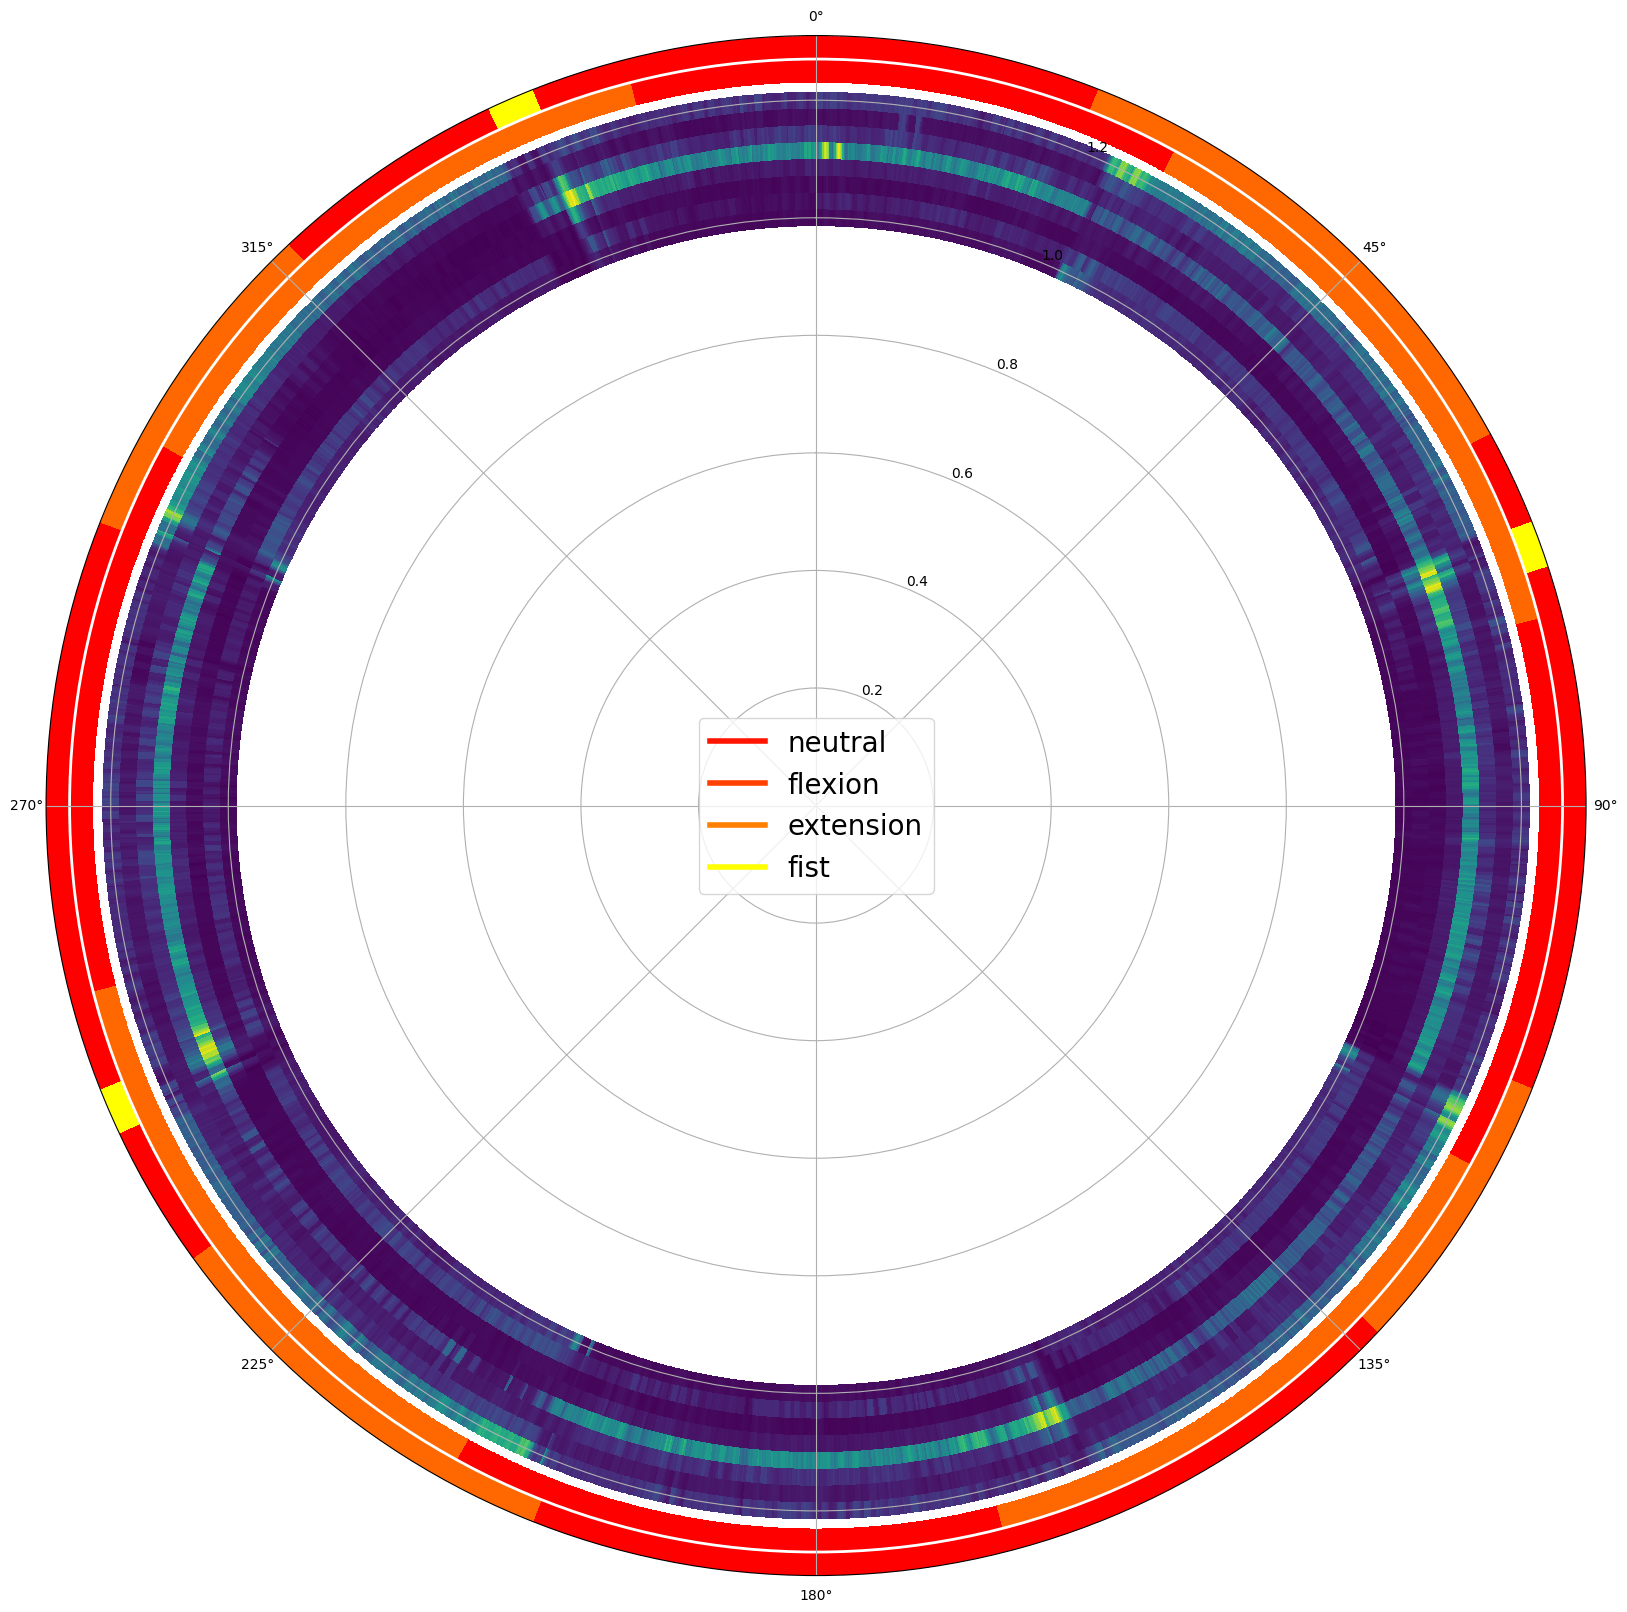

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend import Line2D

# how many samples you watn to view
N = 100
# offset wrt total number of samples
K = 2354

CHANNELS = 8

labels, klabels = [], []

samples = []
for i in range(K, K + N):
  # remove overlap
  sample = np.concatenate([X[i - 1, -10:], X[i, :20]], axis=0)
  labels.append(y[i].item())
  klabels.append(ky[i].item())
  samples.append(sample)

samples = np.concatenate(samples, axis=0)

# prepare polar coordinates
rad = np.linspace(1, 1.2, CHANNELS)
thetas = np.linspace(0, 2 * np.pi, len(samples))
r, th = np.meshgrid(rad, thetas)

labels_heatmap = np.zeros((len(samples), 2), dtype=np.uint8)
for i in range(len(samples)):
  labels_heatmap[i, 0] = gesture2intensity[int2gesture[y[K + i // 30]]]
  labels_heatmap[i, 1] = gesture2intensity[kint2gesture[ky[K + i // 30]]]

fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw={'polar': True})

fig.gca().set_theta_zero_location('N')
fig.gca().set_theta_direction(-1)

# plot data
samples_plot = ax.pcolormesh(th, r, samples)

# plot labels
labels_rad = [1.25, 1.29]
labels_r, labels_th = np.meshgrid(labels_rad, thetas)
cmap = plt.cm.autumn
labels_plot = ax.pcolormesh(labels_th, labels_r, labels_heatmap, cmap=cmap)
legend_elements = [Line2D([0], [0], color=cmap(v), lw=4) for v in gesture2intensity.values()]
ax.legend(legend_elements, [k for k in gesture2intensity.keys()], loc='center', prop={'size': 20})

circle = plt.Circle((0., 0.), 1.27, transform=ax.transData._b, fill=False, edgecolor='white', linewidth=2)
ax.add_patch(circle)

# annotations
time_arrow = patches.FancyArrowPatch((np.pi/4, 0.95), (0., 0.95), arrowstyle='<-, head_width=4, head_length=8',
                             connectionstyle="arc3, rad=0.2")

emg_arrow_start_r, emg_arrow_end_r = 0.6, 0.9
emg_arrow_theta = np.pi/4
emg_channels_arrow = patches.FancyArrowPatch((emg_arrow_theta, emg_arrow_start_r), (emg_arrow_theta, emg_arrow_end_r), arrowstyle='->, head_width=4, head_length=8')
arrow_channel_seps = np.linspace(emg_arrow_start_r * 1.01, emg_arrow_end_r * 0.99, CHANNELS + 1)
emg_arrow_theta_ = emg_arrow_theta - np.pi/2
for sep_step in arrow_channel_seps[:-1]:
  sep = Line2D([emg_arrow_theta * 0.99, emg_arrow_theta * 1.01], [sep_step, sep_step])
  ax.add_patch(sep)

ax.add_patch(time_arrow)
plt.text(0.05, 0.89, 'time', rotation=-3, fontsize=16)

ax.add_patch(emg_channels_arrow)
plt.text(emg_arrow_theta * 1.1, 0.605, 'EMG channels', rotation=45, fontsize=16)

labels_theta = np.pi / 3 * 1.05
plt.text(-labels_theta, 1.39, 'K-means labels (upper)', rotation=53, fontsize=16)
plt.text(labels_theta, 1.115, 'hand-made labels (lower)', rotation=-60, fontsize=16)

# separate samples with a white line. Will slow down the plot generation for huge N
if N <= 300:
  for i in range(N):
      thetas_ = [thetas[i * 30], thetas[i * 30]]
      radii = [0.99, 1.33]
      sep = Line2D(thetas_, radii, color='white')
      ax.add_line(sep)

ax.axis('off')